# This is the development playground for functionalities for thermal profiler on DRU+ with Halliburton.

Now. Let's look at how each parameter affects the step response of the system when compared against the step input test data. This is for water at 600 rpm with 5% step input power.

FLUID DATA FOR step1_10p.csv REFERENCED AT  20-Jun-24 14:35:50:452
###############  step1_10p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 1.81, 1.32, 0.0095]
Ch, Cc, Cf: [2500, 3800, 1155]
###################################################
FLUID DATA FOR step1_50p.csv REFERENCED AT  20-Jun-24 19:01:30:089
###############  step1_50p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 1.81, 1.32, 0.0095]
Ch, Cc, Cf: [2500, 3800, 1155]
###################################################
FLUID DATA FOR step_5p.csv REFERENCED AT  19-Jun-24 15:45:47:206
uh oh... something went horribly wrong! at dates (datetime.datetime(2024, 6, 19, 15, 55, 20, 609), datetime.datetime(2024, 6, 19, 15, 51, 27, 233))
uh oh... something went horribly wrong! at dates (datetime.datetime(2024, 6, 19, 23, 28, 25, 202), datetime.datetime(2024, 6, 19, 23, 19, 55, 168))
###############  step_5p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 1.81, 1.32, 0.0095]
Ch, Cc, Cf: [2500, 3800, 1155]
############################

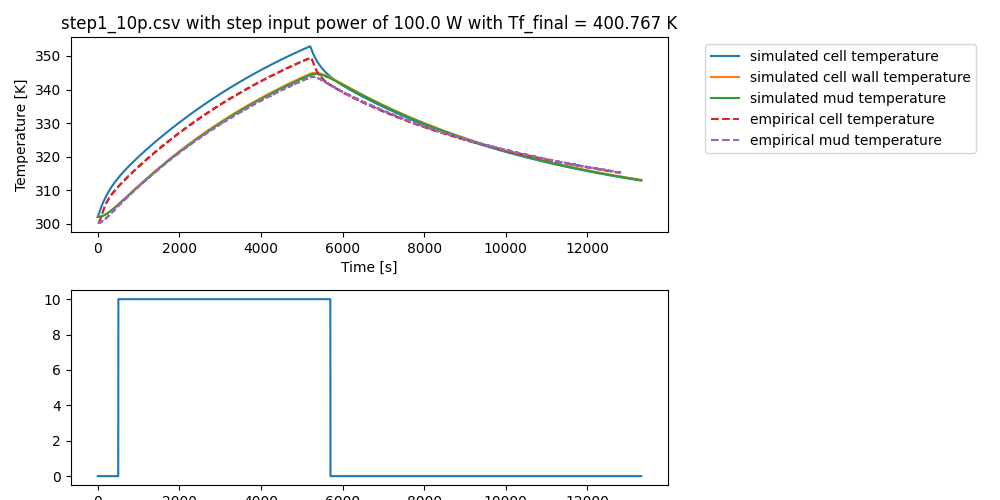

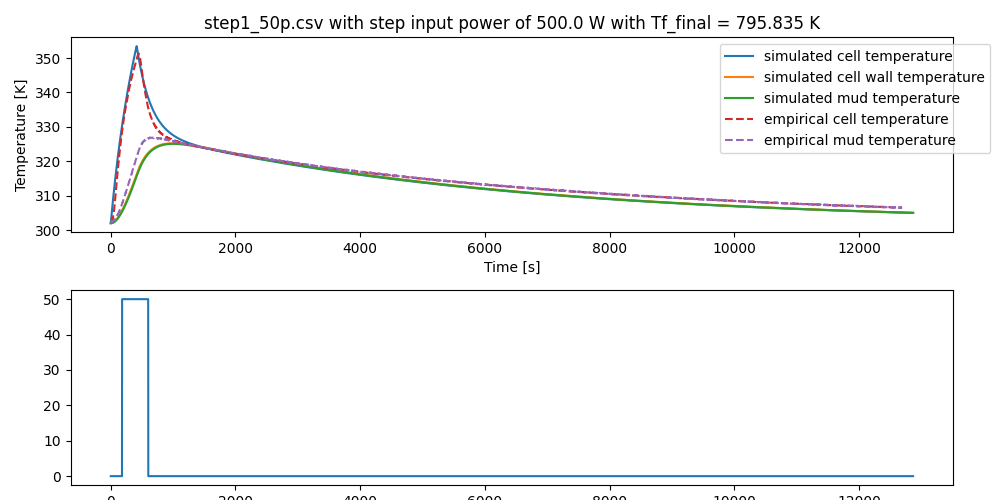

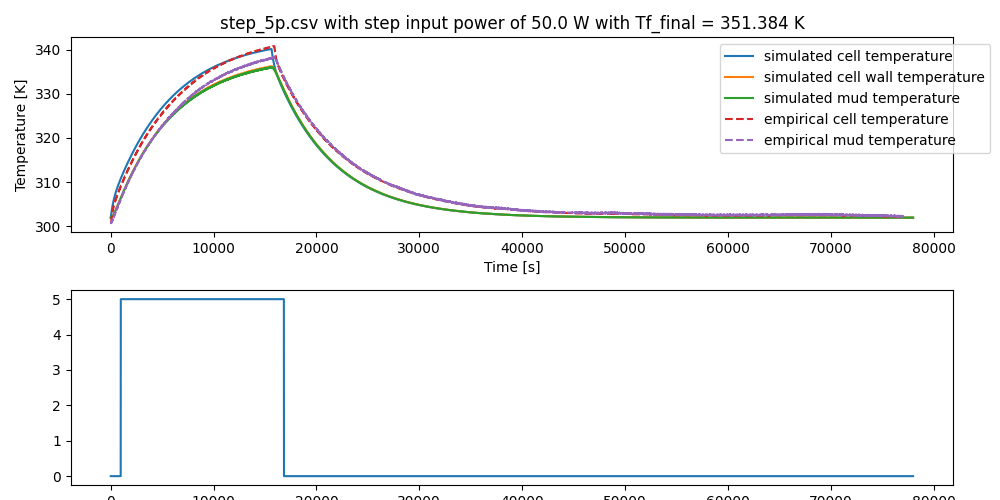

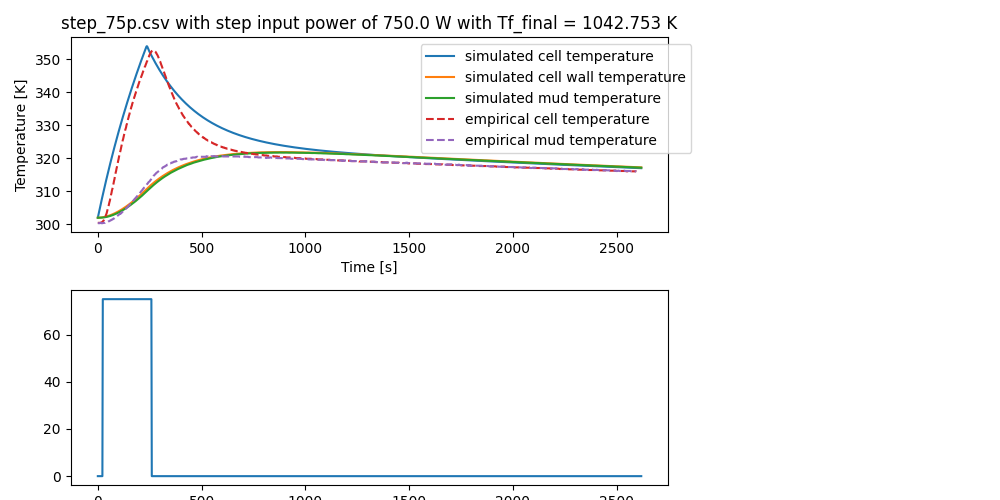

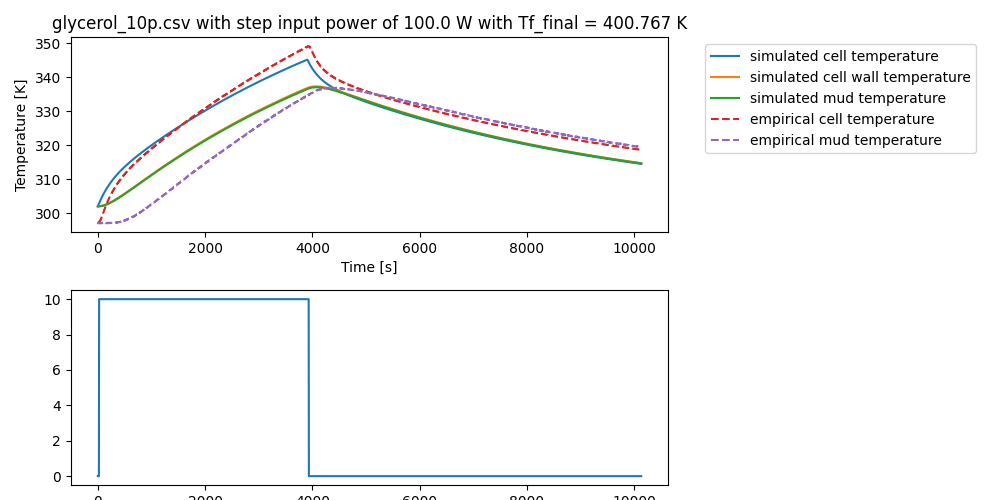

In [61]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["step1_10p.csv", "step1_50p.csv", "step_5p.csv", "step_75p.csv", "glycerol_10p.csv"]:
    step_power = float(filename.split('p')[-2].split('_')[-1])/100
    my_fluid = MysteriousMud(filename)
    my_fluid.importRawData(filename, heaterHeader=True)

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rj,Rfj,Rf]
    # self.thermal_capacitances = [Cc, Cf]


    model.thermal_resistances = [.14, 2.210, 2.02, .0095] # Rf
    model.thermal_capacitances = [2000, 3000, 1200]

    model.thermal_resistances = [.14, 1.810, 1.32, .0095] # Rf
    model.thermal_capacitances = [2500, 3800, 1155]

    model.Tambient = 302


    x0 = np.array([1,1,1]) *  model.Tambient
    temp_cell, temp_mud = model.stepResponse(x0, powerPercentage = step_power)
    model.plot(stepResponse=True)

Let's test on a 3rd order model.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

Ch = 1000 #cap_ss * density_ss * d_heat**2 /4 * np.pi * l_heat * n_heaters
Rc = .1
Rj = 10
Cc = 6000
Cf = 1200
Rf = 0.1
Rfj = 5


Tn = 1500


def ss_model(t,x): # x = [Th-Tamb, Tc-Tamb; Tf-Tamb]

        A = np.array([[-1/Ch * (1/Rc + 1/Rj), 1/(Rc*Ch), 0],
                [1/(Rc*Cc), -1/Cc * (1/Rc + 1/Rf), 1/(Rf*Cc)],
                [0, 1/(Rf*Cf), -1/Cf * (1/Rfj + 1/Rf)]])
        B = np.array([1/Ch, 0, 0]).transpose() 
        C = np.array([0, 0, 1])

        if t > 0 and t < Tn/3:
            p = 100
        else:
            p = 0
        
        d = 0
        if p > 0:
            p = min(abs(p),1000)
        else:
            p = 0

        xdot = A @ x + B*p + d

        #print(x.shape, xdot)
        return xdot

Tambient = 300
tvec = np.linspace(0,Tn,1000)
X0 = np.zeros(3)
sol = solve_ivp(ss_model,(tvec[0],tvec[-1]), X0, t_eval=tvec)

yout = sol.y
temp_mud = yout[2,:] + Tambient
temp_cell = yout[1,:] + Tambient
temp_heater = yout[0,:] + Tambient



plt.figure()
plt.plot(tvec,temp_heater, label = "heater temp")
plt.plot(tvec,temp_cell, label = "cell temp")
plt.plot(tvec,temp_mud, label = "mud temp")

plt.legend()

Looks a lot better!

# Now, testing plotting and simulation suites


In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["calibration_fluid_50p.csv"]:

    step_power = float(filename.split('p')[-2].split('_')[-1])/100
    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.14, 2.210, 2.02, .0095] # Rf
    model.thermal_capacitances = [2000, 3000, 450]
    model.Tambient = 302

    x0 = np.array([1,1,1]) * model.Tambient
    temp_cell, temp_mud = model.stepResponse(x0, powerPercentage = step_power)
    model.plot()
    plt.xlim([0,6000])
 

 

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["water_50p.csv", "water_111p.csv", "water_pid2.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)


    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.14, 1.810, 1.32, .0095] # Rf
    model.thermal_capacitances = [2500, 3800, 1155]
    model.Tambient = 300

    x0 = np.array([1,1,1]) * my_fluid.temp_cell[0]
    temp_cell, temp_mud = model.forcedResponse(x0)
    model.plot()

Now let's use recursive least squares parameter estimation to measure properties in real time!


In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *


# initialize RLS params
n = 8 # number of parameters
m = 3 # number of measured outputs

P0 = np.eye(n) * 1e10

# to simulate this, parse through each time step in a given data set

# read in test data
filename = "water_pid2.csv"
filename = "calibration_fluid_pid1.csv"

my_fluid = MysteriousMud(filename)
my_fluid.importRawData(filename, heaterHeader=True)

Nk = len(my_fluid.tvector)

Pp = P0
Powerp, Thp, Tcp, Tfp = 0,15,15,15


Rc, Rj, Rfj, Rf = [.14, 1.810, 1.32, .0095]
Ch, Cc, Cf = [2500, 3800, 1255]


thetap = np.array([1/Ch, 1-(1/Rj + 1/Rc)/Ch, 1/(Rc*Ch), 1- (1/Rc + 1/Rf)/Cc, 1/Rc/Cc, 1/Rf/Cc, 1/Rf/Cf, 1-(1/Rf + 1/Rfj)/Cf])
c1,c2,c3,c4,c5,c6,c7,c8 = thetap

thetap.resize((n,1))

print("Right constants: ", thetap)

thetap = np.zeros((n,1))

theta_history = []

for k in range(Nk):

    yk = np.array([my_fluid.temp_cell[k], my_fluid.temp_fluid[k],my_fluid.temp_fluid[k]]) - 300

    
    Powerk = my_fluid.heater_dutycycle[k]/100 * 1000 # in Watts now


    Rk = np.eye(m)/10


    Hk = np.matrix([[Powerp, Thp, Tcp, 0,0,0,0,0],[0,0,0,Tcp,Thp,Tfp,0,0],[0,0,0,0,0,0,Tcp, Tfp]])


    bigInverse = (Hk @ Pp @ Hk.T + Rk).I
    Kk = Pp @ Hk.T @ bigInverse

    Pk = (np.eye(n) - (Kk @ Hk)) @ Pp

    #print('##########################')
    #print(Pk)

    theta_error = (yk.reshape(m,1) - (Hk@thetap))

    predicted_y = np.asarray(Hk@thetap)

    thetak =  np.asarray(thetap + Kk @ theta_error)
    thetak[0] = c1
    thetak[1] = c2
    thetak[2] = c3
    thetak[4] = c5
    thetak[3] = 1-c5-thetak[5]

    #print(yk - np.asarray((Hk@thetap).T))

    #thetak = abs(thetak)

    Pp = Pk
    thetap = thetak
    Thp, Tcp, Tfp = list(yk)
    Powerp = Powerk
    theta_history.append(predicted_y)
    

print("Done running RLS!")

print("Parameters: ", thetak)

print(np.max(Pk))

c1,c2,c3,c4,c5,c6,c7,c8 = [x[0] for x in thetak]

Ch = 1/c1
Rc = 1/(Ch*c3)
Rj = 1/((1-c2) * Ch - 1/Rc)
Cc = 1/(Rc*c5)
Rf = 1/(Cc*c6)
Cf = 1/(Rf*c7)
Rfj = 1/(Cf*(1-c8) - 1/Rf)

print("c456 sum [should be close to 1]: ", c4 + c5 + c6)



model = ThermalModel(my_fluid)

model.thermal_resistances = [Rc, Rj,Rfj,Rf]
model.thermal_capacitances = [Ch, Cc, Cf]

model.Tambient = 300

x0 = np.array([304,302,302]) 
temp_cell, temp_mud = model.forcedResponse(x0)
model.plot()



In [ ]:
# look at what RLS is cookin'


mean_error = np.array(theta_history)

plt.figure()
plt.plot(my_fluid.tvector,mean_error[:,0])
plt.plot(my_fluid.tvector,mean_error[:,1])
plt.plot(my_fluid.tvector,mean_error[:,2])

plt.plot(my_fluid.tvector,my_fluid.temp_cell-300,'--')
plt.plot(my_fluid.tvector,my_fluid.temp_fluid-300,'--')

Interesting how the RLS think's it's on the money, when it's not. I'm thinking this is because of the lack of the forgetting factor. Either way, I will try batch LSE then.

Now, implementing a simple L observer. (WIP)

In [ ]:
%matplotlib widget

import statsmodels.api as sm
from dru_thermal_model import *
from data_visualizer import *


# initialize RLS params
n = 8 # number of parameters
m = 3 # number of measured outputs

P0 = np.eye(n) * 1e6

# to simulate this, parse through each time step in a given data set

# read in test data
filename = "water_pid2.csv"

my_fluid = MysteriousMud(filename)
my_fluid.importRawData(filename, heaterHeader=True)

Nk = len(my_fluid.tvector)

Pp = P0
Powerp, Thp, Tcp, Tfp = 0,15,15,15




Rc, Rj, Rfj, Rf = [.14, 1.810, 1.32, .0095]
Ch, Cc, Cf = [2500, 3800, 1255]


thetap = np.array([1/Ch, 1-(1/Rj + 1/Rc)/Ch, 1/(Rc*Ch), 1- (1/Rc + 1/Rf)/Cc, 1/Rc/Cc, 1/Rf/Cc, 1/Rf/Cf, 1-(1/Rf + 1/Rfj)/Cf])
thetap.resize((n,1))

print("Right constants: ", thetap)

thetap = np.zeros((n,1))

theta_history = []



for k in range(Nk):

    yk = np.array([my_fluid.temp_cell[k], my_fluid.temp_fluid[k],my_fluid.temp_fluid[k]]) - 300

    
    Powerk = my_fluid.heater_dutycycle[k]/100 * 1000 # in Watts now

    alpha = .8

    Rk = np.eye(m)/10 


    Hk = np.matrix([[Powerp, Thp, Tcp, 0,0,0,0,0],[0,0,0,Tcp,Thp,Tfp,0,0],[0,0,0,0,0,0,Tcp, Tfp]])


    bigInverse = (Hk @ Pp @ Hk.T + alpha).I
    Kk = Pp @ Hk.T @ bigInverse

    Pk =  (np.eye(n) - (Kk @ Hk)) @ Pp / alpha

    #print('##########################')
    #print(Pk)

    theta_error = (yk.reshape(m,1) - (Hk@thetap))

    thetak =  np.asarray(thetap + Kk @ theta_error)

    #print(yk - np.asarray((Hk@thetap).T))

    #thetak = abs(thetak)

    Pp = Pk
    thetap = thetak
    Thp, Tcp, Tfp = list(yk)
    Powerp = Powerk
    theta_history.append(theta_error)
    

print("Done running RLS!")

print("Parameters: ", thetak)

print(np.max(Pk))

c1,c2,c3,c4,c5,c6,c7,c8 = [x[0] for x in thetak]

Ch = 1/c1
Rc = 1/(Ch*c3)
Rj = 1/((1-c2) * Ch - 1/Rc)
Cc = 1/(Rc*c5)
Rf = 1/(Cc*c6)
Cf = 1/(Rf*c7)
Rfj = 1/(Cf*(1-c8) - 1/Rf)

print("c456 sum [should be close to 1]: ", c4 + c5 + c6)



model = ThermalModel(my_fluid)

model.thermal_resistances = [Rc, Rj,Rfj,Rf]
model.thermal_capacitances = [Ch, Cc, Cf]

model.Tambient = 300

x0 = np.array([1,1,1]) * 315
temp_cell, temp_mud = model.forcedResponse(x0)
model.plot()


# plt.figure()
# plt.plot(my_fluid.tvector,my_fluid.temp_cell,my_fluid.tvector,my_fluid.temp_fluid)


Hmm... What about a brute force approach? We should have all the computation time in the world...
# Exhaustive search on parameter space

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *


# to simulate this, parse through each time step in a given data set

# read in test data
filename = "water_111p.csv"

my_fluid = MysteriousMud(filename)
my_fluid.importRawData(filename, heaterHeader=True)

Nk = len(my_fluid.tvector)

min_error = np.inf



model = ThermalModel(my_fluid)
model.Tambient = 296

x0 = np.array([1,1,1]) * model.Tambient

#model.thermal_resistances = [.14, 2.210, 2.52, .0095] # Rf
#model.thermal_capacitances = [2500, 3800, 1255]

Ch = 2500
Cc = 3800

for cf in np.linspace(1000,5000, 5):
    for Rf in np.linspace(1e-4,.1,10):
        for Rc in np.linspace(1e-2,.5,3):
            for Rfj in np.linspace(1e-2,10,5):
                for Rj in np.linspace(1e-2,10,5):
           
                    
                    Cf = .3*cf

                    model.thermal_resistances = [Rc, Rj,Rfj,Rf]
                    model.thermal_capacitances = [Ch, Cc, Cf]

                    temp_cell, temp_mud = model.forcedResponse(x0)

                    curr_error = (my_fluid.temp_fluid - temp_mud)**2 + (my_fluid.temp_cell - temp_cell)**2
                    print(curr_error)
                    if curr_error < min_error:
                        min_error = curr_error
                        print("error: ", curr_error)
    

print("Done running EPS (exhaustive parameter search)!")



print("\n\nResistances: ", Rc,Rj,Rfj,Rf)
print("Capacitances: ", Ch,Cc,Cf)


model = ThermalModel(my_fluid)

model.thermal_resistances = [Rc, Rj,Rfj,Rf]
model.thermal_capacitances = [Ch, Cc, Cf]

model.Tambient = 296

x0 = np.array([1,1,1]) * model.Tambient
temp_cell, temp_mud = model.forcedResponse(x0)
model.plot()

